In [1]:
import os
import glob
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import feature
from sklearn.svm import SVC
from skimage import feature, io
from skimage.feature import hog
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

In [2]:
# Define the main folder path where the dataset is located
dataset_path = "Amharic OCR Dataset"

In [3]:
# Iterate over each letter in the main folder and create subfolders for processed images
for letter in os.listdir(dataset_path):
    os.makedirs(os.path.join(dataset_path, "processed", letter), exist_ok=True)

In [4]:
# Read each image, resize it to 150x150 pixels, convert it to grayscale, 
# and save the processed image to the corresponding subfolder
for letter_folder in glob.glob(os.path.join(dataset_path, "*")):
    letter = os.path.basename(letter_folder)
    image_paths = glob.glob(os.path.join(letter_folder, "*.jpg")) + glob.glob(os.path.join(letter_folder, "*.png"))
    for image_path in image_paths:
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, (150, 150))
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(dataset_path, "processed", letter, os.path.basename(image_path)), gray_image)

In [5]:
# Define the dataset path for the processed images
processed = os.path.join(dataset_path, "processed")

In [6]:
# Retrieve the list of letter folders in the dataset
letter_folders = glob.glob(os.path.join(processed, "*"))

In [7]:
# Initialize lists to store the features and labels
features = []
labels = []

In [8]:
# Iterate over each letter folder, retrieve the list of image files in the folder, and append the image paths and labels to separate lists
for letter_folder in letter_folders:
    letter = os.path.basename(letter_folder)
    image_paths = glob.glob(os.path.join(letter_folder, "*.jpg")) + glob.glob(os.path.join(letter_folder, "*.png"))
    for image_path in image_paths:
        image = Image.open(image_path)
        image_array = np.array(image)
        features.append(image_array.flatten())
        labels.append(letter)

In [9]:
# Convert the lists to NumPy arrays
features = np.array(features)
labels = np.array(labels)

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [11]:
# Define HOG parameters
orientations = 9  # Number of orientation bins
pixels_per_cell = (10, 10)  # Size of a cell
cells_per_block = (2, 2)  # Number of cells in each block

In [12]:
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
# Extract HOG features
# Compute HOG features
hog_features, hog_image = hog(gray, orientations=orientations,
                              pixels_per_cell=pixels_per_cell,
                              cells_per_block=cells_per_block,
                              transform_sqrt=True,
                              visualize=True)

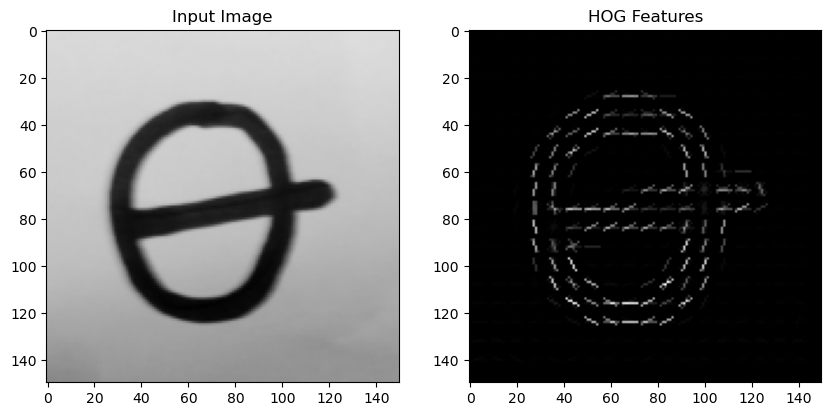

In [13]:
# Plot the input image and its corresponding HOG representation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title("Input Image")

ax2.imshow(hog_image, cmap='gray')
ax2.set_title("HOG Features")

plt.show()

In [14]:
# Extract HOG features for the training and testing data
X_train_hog = np.array([feature.hog(image.reshape((150, 150)), orientations=9, pixels_per_cell=(10, 10),
                                    cells_per_block=(2, 2)) for image in X_train])
X_test_hog = np.array([feature.hog(image.reshape((150, 150)), orientations=9, pixels_per_cell=(10, 10),
                                   cells_per_block=(2, 2)) for image in X_test])

In [15]:
# Implement distance measurement techniques
# Euclidean distance
euclidean_dist = pairwise_distances(X_test, X_train, metric='euclidean')

# Manhattan distance
manhattan_dist = pairwise_distances(X_test, X_train, metric='manhattan')

# Cosine similarity
cosine_sim = cosine_similarity(X_test, X_train)

# Print the distances/similarities
print("Euclidean distance:")
print(euclidean_dist)
print("Manhattan distance:")
print(manhattan_dist)
print("Cosine similarity:")
print(cosine_sim)

Euclidean distance:
[[ 7227.8395804  10524.22025615 16554.96898215 ... 15955.26862826
   8282.22512372 16887.95333958]
 [ 4360.44217941  8915.32607368 16568.02000844 ... 15800.78903093
   5780.85495407 16298.35430343]
 [13212.93589631 16151.29728536  8913.72088412 ...  7565.61768794
  10269.51970639  7058.21478846]
 ...
 [14894.68415241 17203.84669195  8023.1268842  ...  6578.73939292
  11675.88728962  5482.65255146]
 [14401.62424867 16778.67551388  7795.45482958 ...  7187.89878894
  11178.2121558   6465.45698308]
 [15280.62976451 16770.88056722 11665.25006161 ... 10645.65883353
  12505.42578244 10775.983157  ]]
Manhattan distance:
[[ 601897. 1114948. 2280146. ... 2202465.  756353. 2312240.]
 [ 434974. 1199643. 2456069. ... 2299492.  816246. 2406121.]
 [1863863. 1982094.  600768. ...  580901. 1449793.  502332.]
 ...
 [2172494. 2229767.  295321. ...  312278. 1715992.  180123.]
 [2093377. 2155522.  355304. ...  419085. 1638115.  306486.]
 [2212482. 2171013.  593351. ...  600448. 1791666.

In [16]:
# Define a function to evaluate the performance
def evaluate_performance(distances, y_test):
    # Find the index of the nearest neighbor for each test sample
    nearest_neighbors = np.argmin(distances, axis=1)
    
    # Predicted labels based on nearest neighbors
    y_pred = y_train[nearest_neighbors]
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

# Evaluate the performance of Euclidean distance
euclidean_accuracy, euclidean_precision, euclidean_recall, euclidean_f1 = evaluate_performance(euclidean_dist, y_test)

# Evaluate the performance of Manhattan distance
manhattan_accuracy, manhattan_precision, manhattan_recall, manhattan_f1 = evaluate_performance(manhattan_dist, y_test)

# Evaluate the performance of cosine similarity
cosine_accuracy, cosine_precision, cosine_recall, cosine_f1 = evaluate_performance(cosine_sim, y_test)

# Print the evaluation results
print("Euclidean Distance:")
print("Accuracy:", euclidean_accuracy)
print("Precision:", euclidean_precision)
print("Recall:", euclidean_recall)
print("F1 Score:", euclidean_f1)
print()

print("Manhattan Distance:")
print("Accuracy:", manhattan_accuracy)
print("Precision:", manhattan_precision)
print("Recall:", manhattan_recall)
print("F1 Score:", manhattan_f1)
print()

print("Cosine Similarity:")
print("Accuracy:", cosine_accuracy)
print("Precision:", cosine_precision)
print("Recall:", cosine_recall)
print("F1 Score:", cosine_f1)

Euclidean Distance:
Accuracy: 0.014814814814814815
Precision: 0.01316872427983539
Recall: 0.014814814814814815
F1 Score: 0.011522633744855966

Manhattan Distance:
Accuracy: 0.019753086419753086
Precision: 0.029218106995884775
Recall: 0.019753086419753086
F1 Score: 0.015889761815687742

Cosine Similarity:
Accuracy: 0.007407407407407408
Precision: 5.817335660267597e-05
Recall: 0.007407407407407408
F1 Score: 0.00011544011544011543


/Users/bitaniyanassir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bitaniyanassir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bitaniyanassir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bitaniyanassir/anaconda3/lib/python3.11/s

In [17]:
# Train an SVM classifier
svm = SVC()
svm.fit(X_train_hog, y_train)

# Use the trained model for OCR
def recognize(image_path):
    # Read the image
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (150, 150))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    
    # Extract HOG features
    hog_features = feature.hog(gray_image, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2))
    
    # Predict the label using the trained SVM classifier
    predicted_label = svm.predict([hog_features])[0]
    
    return predicted_label

# Example usage
image_path = "Amharic OCR Dataset/processed/ሐ/bitaniya nassir.jpg"
recognized_label = recognize(image_path)
print("Recognized label:", recognized_label)

Recognized label: ሐ
